I've used quite a few things from other kernels of the competetion to get staretd, just changed them so that I can understand them better.

# Install libraries

In [1]:
!pip install segmentation-models
!pip install albumentations
!pip install tensorflow-gpu==1.13.2
!pip install keras

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# Import libraries

In [44]:
import numpy as np
import pandas as pd
import os
import cv2
import collections
import time 
import sys
import tqdm
from multiprocessing import  Pool
from PIL import Image
from functools import partial
import warnings
warnings.filterwarnings("ignore")

train_on_gpu = True

# Visualisation libs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)
import segmentation_models as sm

import keras
from keras import optimizers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate

## Helper functions and constants

In [28]:
# used from notebooks mentioned in the end
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [29]:
#Parameters
LEARNING_RATE = 2e-3
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
BACKBONE = 'efficient4'
BATCH_SIZE=1
SEED=42

# Load Data and Basic analysis

In [30]:
path = 'input/'
os.listdir(path)

['train.csv', 'sample_submission.csv', 'test_images', 'train_images']

In [31]:
train = pd.read_csv(f'{path}/train.csv')
train.shape

(22184, 2)

In [32]:
sample_submission = pd.read_csv(f'{path}/sample_submission.csv')
sample_submission.shape

(14792, 2)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 2 columns):
Image_Label      22184 non-null object
EncodedPixels    11836 non-null object
dtypes: object(2)
memory usage: 346.7+ KB


We have almost 10k+ null `EncodedPixels` in data. We'll add it as a flag in new column later on

In [34]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


`Image_Label` has both our label and image name, we will break them into two columns for further analysis in next steps

## Add new columns

We will add 3 new columns: name, label and has_null_encoded_pxs.

In [35]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def add_features(df):
    df['name'] = df['Image_Label'].apply(lambda x: x.split('_')[0])
    df['label'] = df['Image_Label'].apply(lambda x: x.split('_')[1])
    df['has_null_encoded_pxs'] = df['EncodedPixels'].isnull()
    return df

train = parallelize_dataframe(train, add_features)

train.head(10)

,Image_Label,EncodedPixels,name,label,has_null_encoded_pxs
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,False
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,False
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,True
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,True
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,False
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,False
6,002be4f.jpg_Gravel,NaN,002be4f.jpg,Gravel,True
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,False
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,0031ae9.jpg,Fish,False
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,0031ae9.jpg,Flower,False


# EDA and Augmentation

Let's get the exact count of null and non null EncodedPixels rows

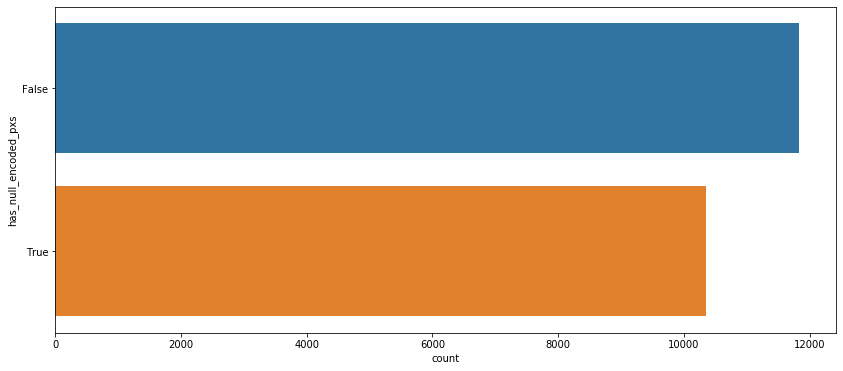

In [36]:
f, ax = plt.subplots(figsize=(14, 6))
ax = sns.countplot(y="has_null_encoded_pxs", data=train)
plt.show()

Also, remember, we've image with multiple mask. So, also check how many images have multiple masks.
We will see this by seeing mask count groupings for images.

In [37]:
train[ train.has_null_encoded_pxs == False ].groupby('name').size().value_counts().reset_index().rename(columns={ 'index': 'Number of masks', '0': 'Image Count'})

,Number of masks,0
0,2,2372
1,3,1560
2,1,1348
3,4,266


# Training model

In [38]:
mask_count_df = train.groupby('name').agg(np.sum).reset_index()
mask_count_df.sort_values('has_null_encoded_pxs', ascending=False, inplace=True)
train_idx, val_idx = train_test_split(mask_count_df.index, test_size=0.2, random_state=42)
print(train_idx.shape, val_idx.shape)

(4436,) (1110,)


In [39]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=f'{path}/train_images',
                 batch_size=BATCH_SIZE, dim=(1400, 2100), n_channels=CHANNELS, reshape=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, random_state=SEED, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['name'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['name'].iloc[ID]
            image_df = self.target_df[self.target_df['name'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y

In [40]:
train_generator = DataGenerator(train_idx, df=mask_count_df, target_df=train)
 
valid_generator = DataGenerator(val_idx, df=mask_count_df, target_df=train)

In [41]:
model = sm.Unet(
           encoder_name=BACKBONE, 
           classes=N_CLASSES,
           activation='sigmoid',
           input_shape=(HEIGHT, WIDTH, CHANNELS))

model.compile(optimizer=optimizers.Adam(lr=LEARNING_RATE), loss=binary_crossentropy, metrics=[dice_coef])

model.summary()

Model: "u-vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [42]:
# using it from dimitreoliveira's kernel
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

Train using `fit_generator`

Note: takes 10-13 minutes per epoch

In [43]:
history = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              epochs=20,
                              callbacks=[es, rlrop],
                              verbose=2).history

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
history

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col', figsize=(20, 12))

ax.plot(history['dice_coef'], label='Train Dice coefficient')
ax.plot(history['val_dice_coef'], label='Validation Dice coefficient')
ax.legend(loc='best')
ax.set_title('Dice coefficient')

plt.xlabel('Epochs')
plt.show()

# Predict test images masks

Add same columns again in sample submission data. 

In [ ]:
sample_submission = parallelize_dataframe(sample_submission, add_features)
sample_submission.head()

Create a new dataframe for unique images only.

In [ ]:
test = pd.DataFrame(sample_submission['name'].unique(), columns=['name'])
test.head()

In [ ]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    test_generator = DataGenerator(
                     batch_idx,
                     df=test,
                     target_df=sample_submission,
                     batch_size=1,
                     reshape=(HEIGHT, WIDTH),
                     dim=(350, 525),
                     n_channels=CHANNELS,
                     n_classes=N_CLASSES,
                     random_state=SEED,
                     base_path=f'{path}/test_images',
                     mode='predict',
                     shuffle=False)

    batch_pred_masks = model.predict_generator(test_generator)

    for j, b in enumerate(batch_idx):
        filename = test['name'].iloc[b]
        image_df = sample_submission[sample_submission['name'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
submission_ready = pd.concat(test_df)

In [ ]:
submission_ready.head()

# Review Submission

TBD

# Submission

In [ ]:
submission = submission_ready[['Image_Label', 'EncodedPixels']]
submission.to_csv('submission.csv', index=False)
print('Added submission file')
submission.head()

In [ ]:
# !pip install Kaggle
# !kaggle competitions submit -c understanding_cloud_organization -f submission.csv -m "Message"

# Code and notebook references

I've looked at lot of different computer vision and segmentation notebooks for this challange to get started.
For this compettion, I looked at notebooks of:
1. [Artgor](https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools)
2. [dimitreoliveira](https://www.kaggle.com/dimitreoliveira/understanding-clouds-eda-and-keras-u-net)

Really thankful to both and others to share their work with us.

Also, for augumentation, I looked at official [sample notebook](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb).
